# 对地理坐标进行聚类

## 对于地理数据应用二分K-均值算法
1. 收集数据：使用Yahoo! PlaceFinder API收集数据。
2. 准备数据：只保留经纬度信息。
3. 分析数据：使用Matplotlib来构建一个二维数据图，其中包含簇与地图。
4. 训练算法：训练不适用无监督学习。
5. 测试算法：使用10.4节中的biKmeans()函数。
6. 使用算法：最后的输出是包含簇及簇中心的地图。

In [1]:
import numpy as np

## K-均值聚类支持函数

In [2]:
# 计算两个向量的欧式距离
def distEclud(vecA, vecB):
    return np.sqrt(np.sum(np.power(vecA - vecB, 2)))

In [3]:
# 为给定数据集构建一个包含k个随机质心的集合。
# 随机质心必须要在整个数据集的边界之内。
def randCent(dataSet, k):
    # 获得dataSet的维度
    n = np.shape(dataSet)[1]
    # 创建k行n列的向量
    centroids = np.mat(np.zeros((k, n)))
    for j in range(n):
        # 获取该列的最小值
        minJ = min(dataSet[:, j])
        # 获取该列的范围
        rangeJ = float(max(dataSet[:, j]) - minJ)
        # 获取随机的列数据，并确保在边界值内
        centroids[:, j] = minJ + rangeJ * np.random.rand(k, 1)
    return centroids

## K-均值聚类算法

In [4]:
# dataSet: 数据集，k: 簇的数目， distMeas: 用来计算距离的函数，createCent: 用来创建初始质心的函数
def kMeans(dataSet, k, distMeas=distEclud, createCent=randCent):
    # 确定数据集中数据点的总数
    m = np.shape(dataSet)[0]
    # 创建一个矩阵来存储每个点的簇分配结果
    # 包括两列： 第一列记录簇索引值，第二列存储误差（当前点到簇质心的距离）
    clusterAssment = np.mat(np.zeros((m, 2)))
    # 初始化创建k个质心
    centroids = createCent(dataSet, k)
    # 设置聚类是否改变的标志变量
    clusterChanged = True
    while clusterChanged:
        clusterChanged = False
        for i in range(m):
            minDist = np.inf; minIndex = -1
            # 寻找最近的质心
            for j in range(k):
                distJI = distMeas(centroids[j, :], dataSet[i, :])
                if distJI < minDist:
                    minDist = distJI; minIndex = j
            # 判断是否最近质心变了
            if clusterAssment[i, 0] != minIndex:
                clusterChanged = True
            # 对误差取平方的目的是更加重视那些远离中心的点
            clusterAssment[i, :] = minIndex, minDist**2
        print(centroids)
        # 更新质心的位置
        for cent in range(k):
            ptsInClust = dataSet[np.nonzero(clusterAssment[:, 0].A == cent)[0]]
            centroids[cent, :] = np.mean(ptsInClust, axis=0)
    # centroids：质心矩阵，clusterAssment：每个点的簇的分配结果
    return centroids, clusterAssment

## 二分 K-均值算法

In [5]:
# dataSet: 数据集，k: 簇的数目，distMeas：用来计算距离的函数
def biKmeans(dataSet, k, distMeas=distEclud):
    # 确定数据集中数据点的总数
    m = np.shape(dataSet)[0]
    # 创建一个矩阵来存储数据集中每个点的簇分配结果和平方误差
    clusterAssment = np.mat(np.zeros((m,2)))
    # 计算整个数据集的质心
    centroid0 = np.mean(dataSet, axis=0).tolist()[0]
    # 使用一个列表保存所有质心
    centList =[centroid0]
    # 计算每个点到质心的误差值
    for j in range(m):#calc initial Error
        clusterAssment[j,1] = distMeas(np.mat(centroid0), dataSet[j,:])**2
    # 对簇进行划分，直到得到想要的簇数目为止
    while (len(centList) < k):
        # 将最小的SEE设置为无穷大
        lowestSSE = np.inf
        for i in range(len(centList)):
            # 将该簇中的所有点看成一个小的数据集
            ptsInCurrCluster = dataSet[np.nonzero(clusterAssment[:,0].A==i)[0],:]#get the data points currently in cluster i
            # 将ptsInCurrCluster输入到函数kMeans()中进行处理k=2，得到两个质心，并给出每个簇的误差值
            centroidMat, splitClustAss = kMeans(ptsInCurrCluster, 2, distMeas)
            # 计算当前的误差之和
            sseSplit = np.sum(splitClustAss[:,1])#compare the SSE to the currrent minimum
            # 计算剩余数据集的误差之后
            sseNotSplit = np.sum(clusterAssment[np.nonzero(clusterAssment[:,0].A!=i)[0],1])
            print("sseSplit, and notSplit: ",sseSplit,sseNotSplit)
            # 如果划分的SSE值最小，则保留本次划分
            if (sseSplit + sseNotSplit) < lowestSSE:
                bestCentToSplit = i
                bestNewCents = centroidMat
                bestClustAss = splitClustAss.copy()
                lowestSSE = sseSplit + sseNotSplit
        # 得到两个编号为0和1的结果簇，需要将这些簇编号修改为划分簇及新加簇的编号
        bestClustAss[np.nonzero(bestClustAss[:,0].A == 1)[0],0] = len(centList) #change 1 to 3,4, or whatever
        bestClustAss[np.nonzero(bestClustAss[:,0].A == 0)[0],0] = bestCentToSplit
        print('the bestCentToSplit is: ',bestCentToSplit)
        print('the len of bestClustAss is: ', len(bestClustAss))
        # 新的簇分配结果被更新，新的质心会被添加到centList中
        centList[bestCentToSplit] = bestNewCents[0,:].tolist()[0]#replace a centroid with two best centroids 
        centList.append(bestNewCents[1,:].tolist()[0])
        clusterAssment[np.nonzero(clusterAssment[:,0].A == bestCentToSplit)[0],:]= bestClustAss#reassign new clusters, and SSE
    return np.mat(centList), clusterAssment

## 球面距离计算

In [6]:
# 返回地球表面两点之间的距离。
def distSLC(vecA, vecB):#Spherical Law of Cosines
    # 使用余弦定理来计算两点距离
    a = np.sin(vecA[0,1] * np.pi / 180) * np.sin(vecB[0,1] * np.pi / 180)
    b = np.cos(vecA[0,1] * np.pi / 180) * np.cos(vecB[0,1] * np.pi / 180) * np.cos(np.pi * (vecB[0,0] - vecA[0,0]) /180)
    return np.arccos(a + b) * 6371.0 

## 数据导入函数

In [7]:
def loadDataSet(fileName):      #general function to parse tab -delimited floats
    dataMat = []                #assume last column is target value
    fr = open(fileName)
    for line in fr.readlines():
        curLine = line.strip().split('\t')
        fltLine = list(map(float,curLine)) #map all elements to float()
        dataMat.append(fltLine)
    return dataMat

## 聚类及簇绘图函数

In [8]:
import matplotlib
import matplotlib.pyplot as plt

# numClust: 希望得到的簇数目
def clusterClubs(numClust=5):
    # 创建一个空列表
    datList = []
    # 打开文件并获得第4列和第5列，这两列分别对应纬度和经度
    for line in open('places.txt').readlines():
        lineArr = line.split('\t')
        datList.append([float(lineArr[4]), float(lineArr[3])])
    datMat = np.mat(datList)
    # 调用biKmeans算法得到簇和质心
    myCentroids, clustAssing = biKmeans(datMat, numClust, distMeas=distSLC)
    fig = plt.figure()
    rect=[0.1,0.1,0.8,0.8]
    # 构建一个标记形状的列表用于绘制散点图
    scatterMarkers=['s', 'o', '^', '8', 'p', \
                    'd', 'v', 'h', '>', '<']
    axprops = dict(xticks=[], yticks=[])
    ax0=fig.add_axes(rect, label='ax0', **axprops)
    # 基于图片创建矩阵
    imgP = plt.imread('Portland.png')
    # 绘制图片矩阵
    ax0.imshow(imgP)
    ax1=fig.add_axes(rect, label='ax1', frameon=False)
    for i in range(numClust):
        ptsInCurrCluster = datMat[np.nonzero(clustAssing[:,0].A==i)[0],:]
        # 使用标记形状
        markerStyle = scatterMarkers[i % len(scatterMarkers)]
        ax1.scatter(ptsInCurrCluster[:,0].flatten().A[0], ptsInCurrCluster[:,1].flatten().A[0], marker=markerStyle, s=90)
    # 使用十字标记来表示簇中心并在图中显示    
    ax1.scatter(myCentroids[:,0].flatten().A[0], myCentroids[:,1].flatten().A[0], marker='+', s=300)
    plt.show()

[[-122.65799047   45.43092601]
 [-122.71964587   45.4724294 ]]
[[-122.5567298    45.48615596]
 [-122.67425939   45.52716507]]
[[-122.54949607   45.50213368]
 [-122.68779922   45.51925412]]
[[-122.55355106   45.51221244]
 [-122.69924389   45.51238822]]
[[-122.55095081   45.5149589 ]
 [-122.69753113   45.51014305]]
[[-122.54868607   45.51882187]
 [-122.69551477   45.50729503]]
sseSplit, and notSplit:  3043.2633161055337 0.0
the bestCentToSplit is:  0
the len of bestClustAss is:  69
[[-122.44110794   45.45608451]
 [-122.51975297   45.45241597]]
[[-122.42811233   45.485694  ]
 [-122.56208315   45.52250274]]
sseSplit, and notSplit:  511.80653761865034 2191.824427523823
[[-122.83080931   45.63238127]
 [-122.82346695   45.57351748]]
[[-122.842918     45.646831  ]
 [-122.69163574   45.50362303]]
[[-122.7859395    45.62095   ]
 [-122.69062695   45.50115151]]
[[-122.74585725   45.6052665 ]
 [-122.68976134   45.49609829]]
[[-122.72070683   45.59796783]
 [-122.69093439   45.49080906]]
[[-122.72072

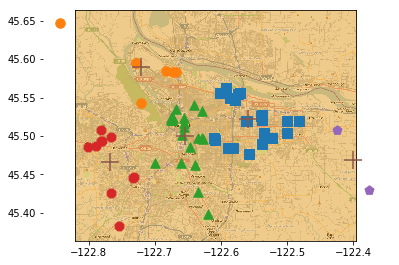

In [9]:
clusterClubs(5)